In [1]:
import sys
sys.path.append("../")

from torch import nn
from models import DisenrangledNetwork

import torch
import numpy as np
from data_utils import load_shape
from matplotlib import pyplot as plt
from train import train_disentangle
from utils import plot_swapped_styles

In [2]:
torch.manual_seed(123)
import numpy as np
np.random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(self.conv_feat_size[0], out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=nb_channels, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(nb_channels, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Sequential(
            nn.Linear(in_features=self.dense_feature_size, out_features=1024),
            nn.ReLU(True), )

        self.share_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.style_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )


    def forward(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        z_style = self.style_feat(feat)
        return z_share, z_style

    def forward_style(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_style = self.style_feat(feat)
        return z_style

In [4]:
source_train_loader = load_shape(batch_size=128, data_size=20000, shuffle=True)

In [5]:
learning_rate = 5e-4

encoder = Encoder(latent_space_dim=10, img_size=(3,32,32), nb_channels=3)
conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=20, conv_feat_size=conv_feat_size, nb_channels=3)
classifier = nn.Sequential(nn.Dropout2d(0.2),
                         nn.Linear(in_features=10, out_features=4),
                         nn.LogSoftmax())

model = DisenrangledNetwork(encoder, decoder_source, classifier).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_disentangle(model, optimizer, source_train_loader, epochs=50, beta_max=10, running_beta=10, show_images=False, alpha_min=10, alpha_max=10)

  0%|          | 0/50 [00:00<?, ?it/s]/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 50/50 [04:45<00:00,  5.72s/it]


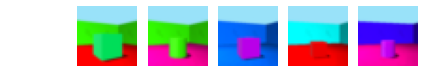

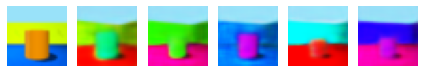

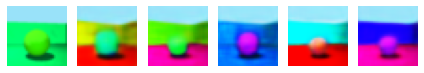

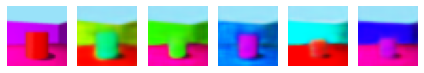

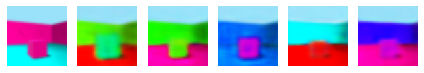

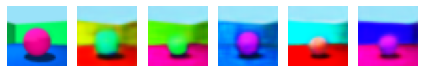

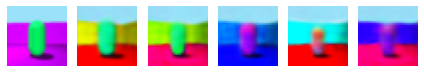

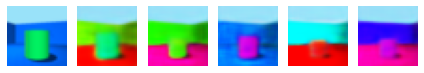

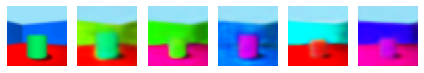

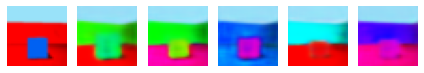

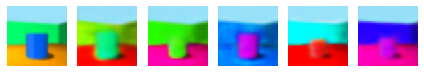

In [6]:
plot_swapped_styles(model, source_train_loader)